In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy import stats
from galpy.util import coords, plot, conversion, multi
import cmasher as cmr
from scipy import ndimage as nd
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table, hstack

## Load astroNN DR17 data file (Leung & Bovy 2019a,b, Mackereth 2019, Montalban 2021) 

Data file, description and references available at https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=the-astronn-catalog-of-abundances,-distances,-and-ages-for-apogee-dr17-stars

In [2]:
try:
    astroNN = Table.read('apogee_astroNN-DR17.fits', format='fits')
except:
    print('Data file not found; download from SDSS website')

## Plotting functions adapted from Bovy et al. (2019) and Leung et al. (2023)

In [3]:
def bin_face_on(data,tag,zcut=0.3,bins=[50,50],range=[[-8.,18],[-13.,13]],
          statistic='median',minN=10,feh_err_cut=0.05,xh_err_cut=0.05):
    if callable(tag):
        tagged_data= tag(data)
        tag= 'DUMMY'
    else:
        tagged_data= data[tag]
        
    indx= (np.fabs(data['galz']) < zcut)
    if 'LOGG_ERR' in data.dtype.fields:
        indx*= (tagged_data > -9000.)\
              *(True^np.isnan(tagged_data))\
              *(data['LOGG_ERR'] < 0.2)\
              *(data['weighted_dist']/data['weighted_dist_error'] > 5)
        if 'FE' in tag:
            indx*= (data['FE_H_ERR'] < feh_err_cut)
        if '_FE' in tag:
            indx*= (data['X_H_ERR'][:,_elemIndx(tag.split('_')[0].upper())] < xh_err_cut)
    tdata= data[indx]
    tagged_data= tagged_data[indx]
    N,xe,ye= stats.binned_statistic_2d(\
                tdata['galr']*np.cos(tdata['galphi']),
                tdata['galr']*np.sin(tdata['galphi']),
                tagged_data,
                statistic='count',
                bins=bins,range=range)[:3]
    binthis= tagged_data
    out= stats.binned_statistic_2d(\
                tdata['galr']*np.cos(tdata['galphi']),
                tdata['galr']*np.sin(tdata['galphi']),
                binthis,
                statistic=statistic,
                bins=bins,range=range)[0]
    out[N < minN]= np.nan
    return (out,xe,ye)
    
def plot_kinematics(VT,VR,VTR,VZ,VTT,xe,ye,
                    vmins=[None,None,None],
                    vmaxs=[None,None,None],
                    xlim=(-18.,8.),
                    ylim=(-13.,13.),
                    figsize=(30,5.6),gcf=False,
                    **kwargs):
    if gcf: fig= plt.gcf()
    else: fig = f, axs = plt.subplots(1, 5,figsize=(27,5.6), sharey=True)
    X,Y= np.meshgrid(xe,ye)
    gs = gridspec.GridSpec(1,5)
    for ii, (H,clabel,cmap) in enumerate(zip([VT,VR,VTR,VZ,VTT],
                                        [r'$v_{\mathrm{R}}\,(\mathrm{km\,s}^{-1})$',
                                         r'$v_z\,(\mathrm{km\,s}^{-1})$',
                                         r'$-v_\phi\,(\mathrm{km\,s}^{-1})$',
                                         r'$-v_\phi/R\,(\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1})$',
                                         r'$\langle\mid v_{\mathrm{R}}/v_{\mathrm{tot}}\mid\rangle $'],
                                             ['coolwarm','coolwarm','viridis_r',cmr.ghostlight,cmr.dusk])):
        fss=25
        ax=axs[ii]
        H= np.ma.array(H)
        H.mask= np.isnan(H)
        m= ax.imshow(H.T,vmin=vmins[ii],vmax=vmaxs[ii],
                     cmap=cmap,**kwargs)
        ax.set_xlim(100,0)
        ax.set_ylim(0,100)
        ax.set_xlabel(r'$X\,(\mathrm{kpc})$',fontsize=20)
        if ii == 0:
            ax.set_ylabel(r'$Y\,(\mathrm{kpc})$',fontsize=20)
        ax_divider= make_axes_locatable(ax)
        cax= ax_divider.append_axes("top", size="7%", pad="2%")
        cbar= plt.colorbar(m,cax=cax,orientation='horizontal')

        cbar.set_label(clabel,fontsize=20)
        cax.xaxis.set_ticks_position("top")
        cax.xaxis.set_label_position("top")
        ax.tick_params(axis='both', labelsize=20)

        lfac=100./26.
        ax.set_xticks([lfac*3,lfac*8,lfac*13,lfac*18,lfac*23])
        ax.set_yticks([lfac*3,lfac*8,lfac*13,lfac*18,lfac*23])
        ax.set_yticklabels([-10,-5,0,5,10])
        ax.set_xticklabels([5,0,-5,-10,-15])
        
        cax.tick_params(axis='both', labelsize=20)
        if ii==1:
            cax.set_xticks([-8,-4,0,4,8])
        if ii==2:
            cax.set_xticks([0,50,100,150,200])
        if ii==3:
            cax.set_xticks([30,40,50,60])
        if ii==4:
            cax.set_xticks([0.1,0.2,0.3,0.4,0.5])

        plt.sca(ax)
        plt.subplots_adjust(hspace=0.01,wspace=0.01)
        plot._add_ticks()

    return None   

## Figure 5 (AstroNN kinematics maps of the Milky Way disc)

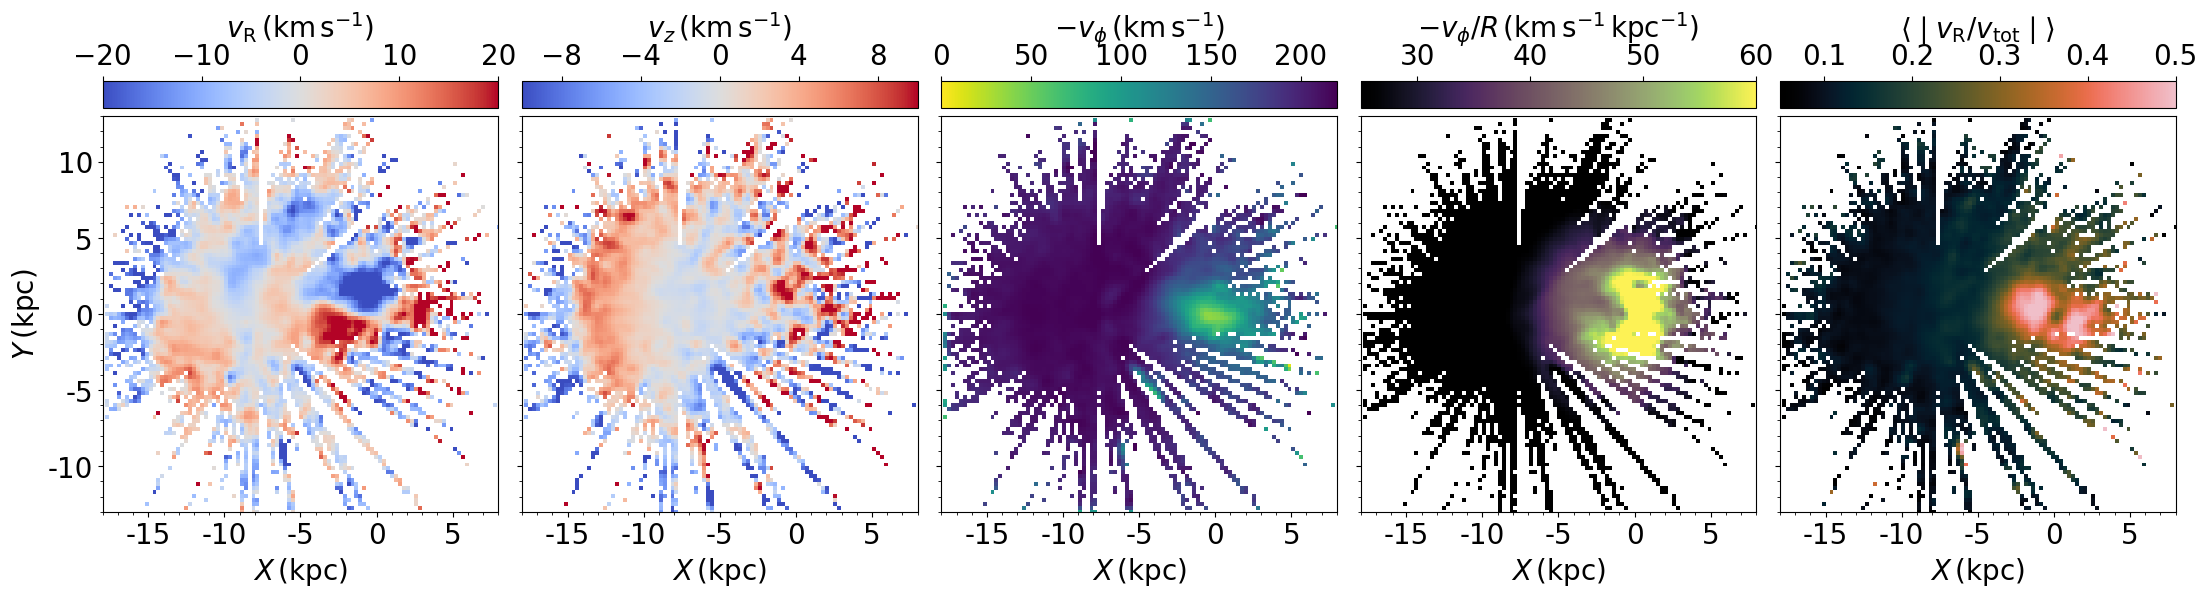

In [4]:
xstddev=1.
minn=2
zcutt=2.
binno=[100,100]

VT,xe,ye= bin_face_on(astroNN,'galvt',minN=minn,zcut=zcutt,bins=binno)
VR,xe,ye= bin_face_on(astroNN,'galvr',minN=minn,zcut=zcutt,bins=binno)
VTR,xe,ye= bin_face_on(astroNN,lambda x: x['galvt']/x['galr'],minN=minn,zcut=zcutt,bins=binno)
VZ,xe,ye= bin_face_on(astroNN,'galvz',minN=minn,zcut=zcutt,bins=binno)
VTT,xe,ye= bin_face_on(astroNN,lambda x: np.fabs(x['galvr'])/np.sqrt(x['galvr']**2+x['galvt']**2+x['galvz']**2),minN=minn,zcut=zcutt,bins=binno)

plot_kinematics(convolve(VR,Gaussian2DKernel(x_stddev=xstddev),preserve_nan=True),
                 convolve(VZ,Gaussian2DKernel(x_stddev=xstddev),preserve_nan=True),                 
                 convolve(VT,Gaussian2DKernel(x_stddev=xstddev),preserve_nan=True),
                 convolve(VTR,Gaussian2DKernel(x_stddev=xstddev),preserve_nan=True),
                 convolve(VTT,Gaussian2DKernel(x_stddev=xstddev),preserve_nan=True),
                xe,ye,
                vmins=[-20.,-10.,0.,25.,0.05],
                vmaxs=[20.,10.,220.,60.,0.5])

#plt.savefig('fig5_disc_kinematic_maps',bbox_inches='tight')

plt.show()